Type 'upload' to load from file or 'webcam' to capture:  webcam


Press SPACE to capture, or ESC to cancel.
Image captured!


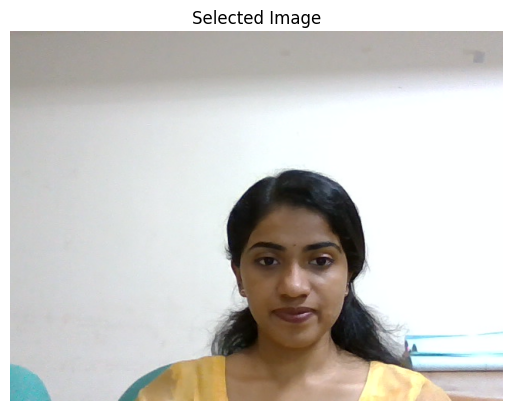

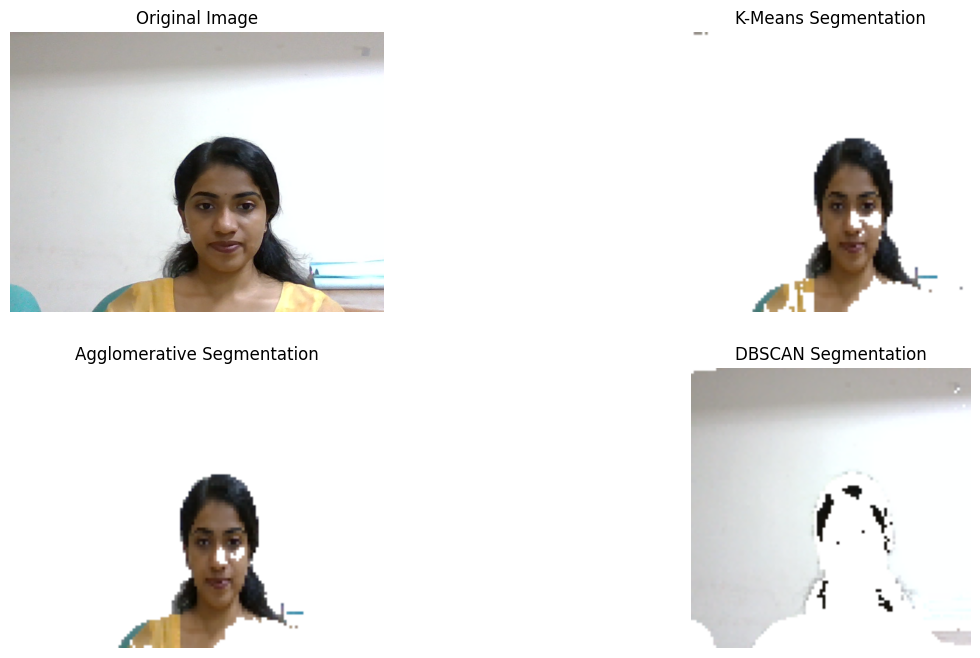

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# --- Load image from file path ---
def load_image_file(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- Capture from webcam (press space to capture) ---
def capture_from_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return None
    
    print("Press SPACE to capture, or ESC to cancel.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        cv2.imshow("Webcam - Press SPACE to capture", frame)
        key = cv2.waitKey(1) & 0xFF

        if key == 27:  # ESC key
            print("Capture canceled.")
            cap.release()
            cv2.destroyAllWindows()
            return None
        elif key == 32:  # SPACE key
            print("Image captured!")
            cap.release()
            cv2.destroyAllWindows()
            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Flatten image ---
def flatten_image(img, resize_dim=(100, 100)):
    img_resized = cv2.resize(img, resize_dim)
    pixels = img_resized.reshape((-1, 3))
    return img_resized, pixels

# --- Clustering functions ---
def kmeans_segmentation(pixels, img_shape, k=2, mask_cluster=0):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    segmented = pixels.copy()
    segmented[labels == mask_cluster] = [255, 255, 255]
    return segmented.reshape(img_shape).astype(np.uint8)

def agglomerative_segmentation(pixels, img_shape, k=2, mask_cluster=0):
    agglo = AgglomerativeClustering(n_clusters=k)
    labels = agglo.fit_predict(pixels)
    segmented = pixels.copy()
    segmented[labels == mask_cluster] = [255, 255, 255]
    return segmented.reshape(img_shape).astype(np.uint8)

def dbscan_segmentation(pixels, img_shape, eps=5, min_samples=50):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(pixels)
    segmented = pixels.copy()
    segmented[labels == -1] = [255, 255, 255]
    return segmented.reshape(img_shape).astype(np.uint8)

# --- Choose upload or webcam ---
choice = input("Type 'upload' to load from file or 'webcam' to capture: ").strip().lower()

if choice == "upload":
    path = input("Enter the image path: ").strip()
    img_rgb = load_image_file(path)
elif choice == "webcam":
    img_rgb = capture_from_webcam()
    if img_rgb is None:
        raise ValueError("No image captured.")
else:
    raise ValueError("Invalid choice")

# Display chosen image
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Selected Image")
plt.show()

# --- Process image ---
img_resized, pixels = flatten_image(img_rgb)

seg_kmeans = kmeans_segmentation(pixels, img_resized.shape)
seg_agglo = agglomerative_segmentation(pixels, img_resized.shape)
seg_dbscan = dbscan_segmentation(pixels, img_resized.shape)

# --- Show results ---
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(seg_kmeans)
plt.title("K-Means Segmentation")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(seg_agglo)
plt.title("Agglomerative Segmentation")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(seg_dbscan)
plt.title("DBSCAN Segmentation")
plt.axis("off")

plt.show()

Type 'upload' to load from file or 'webcam' to capture:  webcam


Press SPACE to capture, or ESC to cancel.
Image captured!


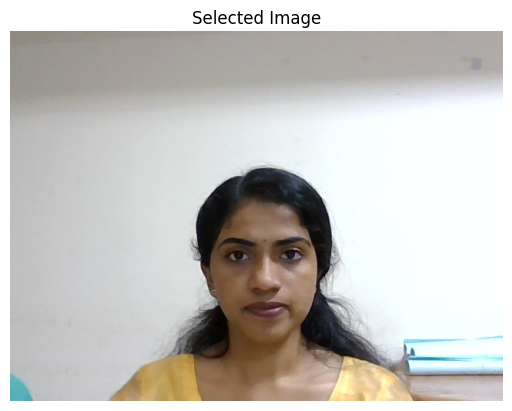

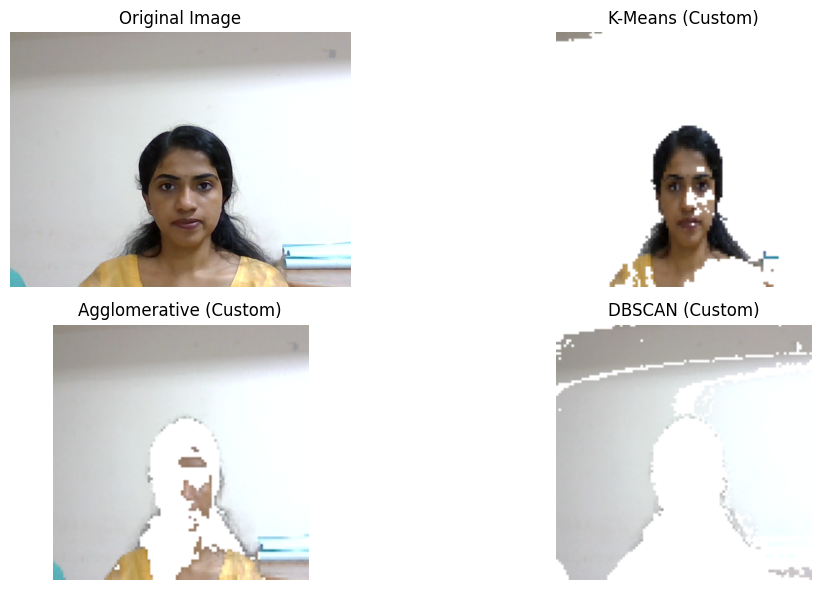

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster

# =========================
# IMAGE LOADING FUNCTIONS
# =========================
def load_image_file(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def capture_from_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return None
    
    print("Press SPACE to capture, or ESC to cancel.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        cv2.imshow("Webcam - Press SPACE to capture", frame)
        key = cv2.waitKey(1) & 0xFF

        if key == 27:  # ESC key
            print("Capture canceled.")
            cap.release()
            cv2.destroyAllWindows()
            return None
        elif key == 32:  # SPACE key
            print("Image captured!")
            cap.release()
            cv2.destroyAllWindows()
            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# =========================
# IMAGE PROCESSING
# =========================
def flatten_image(img, resize_dim=(100, 100)):
    img_resized = cv2.resize(img, resize_dim)
    pixels = img_resized.reshape((-1, 3))
    return img_resized, pixels

# =========================
# CUSTOM IMPLEMENTATIONS
# =========================
def custom_kmeans(pixels, k=2, max_iters=100, tol=1e-4):
    np.random.seed(42)
    centroids = pixels[np.random.choice(len(pixels), k, replace=False)]

    for _ in range(max_iters):
        distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([
            pixels[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
            for i in range(k)
        ])

        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return labels

def custom_agglomerative(pixels, k=2):
    Z = linkage(pixels, method='ward')
    labels = fcluster(Z, t=k, criterion='maxclust') - 1
    return labels

def custom_dbscan(pixels, eps=5, min_samples=50):
    labels = np.full(len(pixels), -1)
    visited = np.zeros(len(pixels), dtype=bool)
    cluster_id = 0

    def region_query(idx):
        return np.where(np.linalg.norm(pixels - pixels[idx], axis=1) < eps)[0]

    for i in range(len(pixels)):
        if visited[i]:
            continue
        visited[i] = True
        neighbors = region_query(i)
        if len(neighbors) < min_samples:
            continue
        labels[neighbors] = cluster_id
        queue = list(neighbors)
        while queue:
            point = queue.pop()
            if not visited[point]:
                visited[point] = True
                new_neighbors = region_query(point)
                if len(new_neighbors) >= min_samples:
                    queue.extend(new_neighbors)
                    labels[new_neighbors] = cluster_id
        cluster_id += 1
    return labels

# =========================
# SEGMENTATION WRAPPERS
# =========================
def segment_with_labels(pixels, labels, img_shape, mask_label=0):
    segmented = pixels.copy()
    segmented[labels == mask_label] = [255, 255, 255]
    return segmented.reshape(img_shape).astype(np.uint8)

# =========================
# MAIN SCRIPT
# =========================
choice = input("Type 'upload' to load from file or 'webcam' to capture: ").strip().lower()

if choice == "upload":
    path = input("Enter the image path: ").strip()
    img_rgb = load_image_file(path)
elif choice == "webcam":
    img_rgb = capture_from_webcam()
    if img_rgb is None:
        raise ValueError("No image captured.")
else:
    raise ValueError("Invalid choice")

plt.imshow(img_rgb)
plt.axis("off")
plt.title("Selected Image")
plt.show()

# Flatten
img_resized, pixels = flatten_image(img_rgb)

# Run custom segmentations
labels_kmeans = custom_kmeans(pixels, k=2)
labels_agglo = custom_agglomerative(pixels, k=2)
labels_dbscan = custom_dbscan(pixels, eps=5, min_samples=50)

seg_kmeans = segment_with_labels(pixels, labels_kmeans, img_resized.shape)
seg_agglo = segment_with_labels(pixels, labels_agglo, img_resized.shape)
seg_dbscan = segment_with_labels(pixels, labels_dbscan, img_resized.shape, mask_label=-1)

# Show results
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(seg_kmeans)
plt.title("K-Means (Custom)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(seg_agglo)
plt.title("Agglomerative (Custom)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(seg_dbscan)
plt.title("DBSCAN (Custom)")
plt.axis("off")

plt.tight_layout()
plt.show()

Type 'upload' to load from file or 'webcam' to capture:  webcam


Press SPACE to capture, or ESC to cancel.
Image captured!


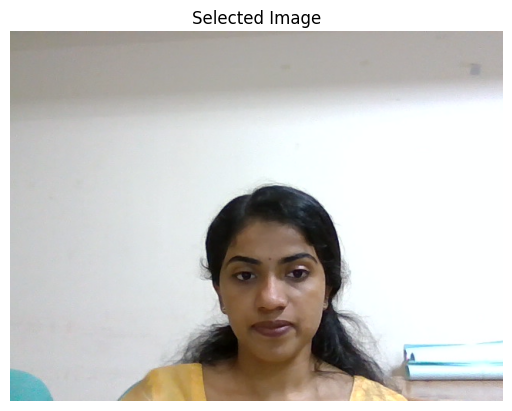

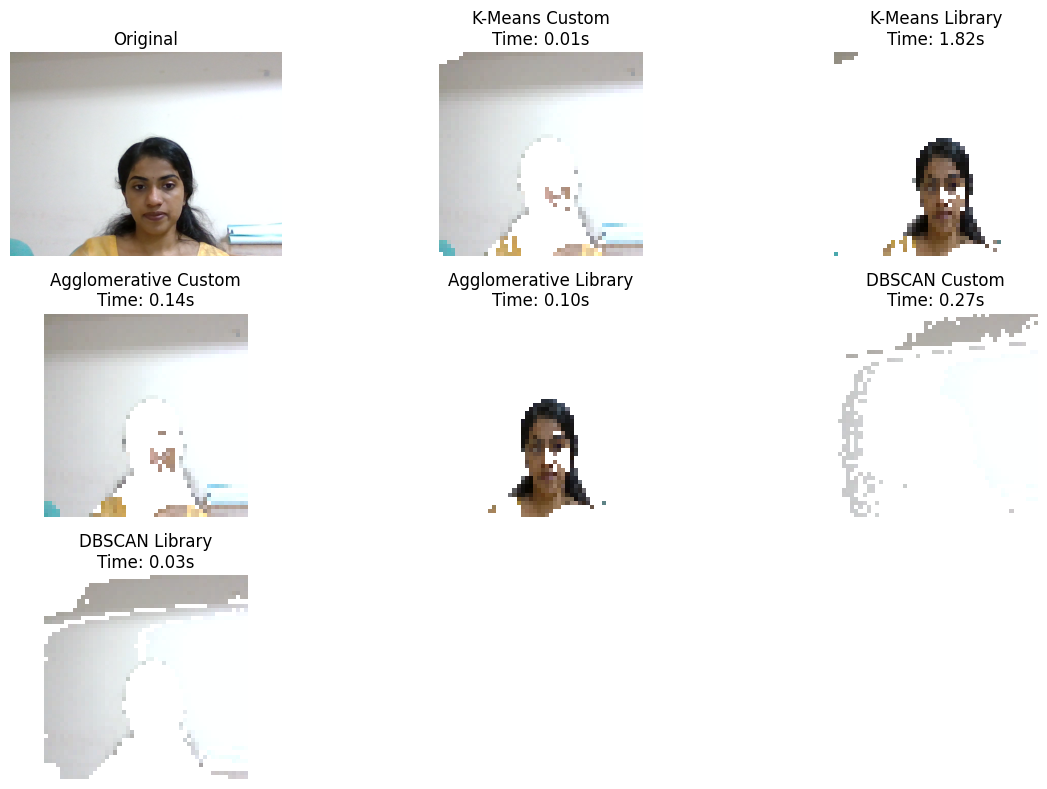

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# =========================
# IMAGE LOADING FUNCTIONS
# =========================
def load_image_file(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def capture_from_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return None
    
    print("Press SPACE to capture, or ESC to cancel.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        cv2.imshow("Webcam - Press SPACE to capture", frame)
        key = cv2.waitKey(1) & 0xFF

        if key == 27:  # ESC key
            print("Capture canceled.")
            cap.release()
            cv2.destroyAllWindows()
            return None
        elif key == 32:  # SPACE key
            print("Image captured!")
            cap.release()
            cv2.destroyAllWindows()
            return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# =========================
# IMAGE PROCESSING
# =========================
def flatten_image(img, resize_dim=(50, 50)):
    img_resized = cv2.resize(img, resize_dim)
    pixels = img_resized.reshape((-1, 3))
    return img_resized, pixels

# =========================
# CUSTOM IMPLEMENTATIONS
# =========================
def custom_kmeans(pixels, k=2, max_iters=100, tol=1e-4):
    np.random.seed(42)
    centroids = pixels[np.random.choice(len(pixels), k, replace=False)]

    for _ in range(max_iters):
        distances = np.linalg.norm(pixels[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([
            pixels[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
            for i in range(k)
        ])

        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return labels

def custom_agglomerative(pixels, k=2):
    Z = linkage(pixels, method='ward')
    labels = fcluster(Z, t=k, criterion='maxclust') - 1
    return labels

def custom_dbscan(pixels, eps=5, min_samples=50):
    labels = np.full(len(pixels), -1)
    visited = np.zeros(len(pixels), dtype=bool)
    cluster_id = 0

    def region_query(idx):
        return np.where(np.linalg.norm(pixels - pixels[idx], axis=1) < eps)[0]

    for i in range(len(pixels)):
        if visited[i]:
            continue
        visited[i] = True
        neighbors = region_query(i)
        if len(neighbors) < min_samples:
            continue
        labels[neighbors] = cluster_id
        queue = list(neighbors)
        while queue:
            point = queue.pop()
            if not visited[point]:
                visited[point] = True
                new_neighbors = region_query(point)
                if len(new_neighbors) >= min_samples:
                    queue.extend(new_neighbors)
                    labels[new_neighbors] = cluster_id
        cluster_id += 1
    return labels

# =========================
# SEGMENTATION WRAPPER
# =========================
def segment_with_labels(pixels, labels, img_shape, mask_label=0):
    segmented = pixels.copy()
    segmented[labels == mask_label] = [255, 255, 255]
    return segmented.reshape(img_shape).astype(np.uint8)

# =========================
# MAIN SCRIPT
# =========================
choice = input("Type 'upload' to load from file or 'webcam' to capture: ").strip().lower()

if choice == "upload":
    path = input("Enter the image path: ").strip()
    img_rgb = load_image_file(path)
elif choice == "webcam":
    img_rgb = capture_from_webcam()
    if img_rgb is None:
        raise ValueError("No image captured.")
else:
    raise ValueError("Invalid choice")

plt.imshow(img_rgb)
plt.axis("off")
plt.title("Selected Image")
plt.show()

# Flatten
img_resized, pixels = flatten_image(img_rgb)

# =========================
# RUN AND TIME COMPARISONS
# =========================
results = {}
times = {}

# --- Custom K-Means ---
start = time.time()
labels_kmeans_custom = custom_kmeans(pixels, k=2)
times["K-Means Custom"] = time.time() - start
results["K-Means Custom"] = segment_with_labels(pixels, labels_kmeans_custom, img_resized.shape)

# --- Library K-Means ---
start = time.time()
labels_kmeans_lib = KMeans(n_clusters=2, n_init=10, random_state=42).fit_predict(pixels)
times["K-Means Library"] = time.time() - start
results["K-Means Library"] = segment_with_labels(pixels, labels_kmeans_lib, img_resized.shape)

# --- Custom Agglomerative ---
start = time.time()
labels_agglom_custom = custom_agglomerative(pixels, k=2)
times["Agglomerative Custom"] = time.time() - start
results["Agglomerative Custom"] = segment_with_labels(pixels, labels_agglom_custom, img_resized.shape)

# --- Library Agglomerative ---
start = time.time()
labels_agglom_lib = AgglomerativeClustering(n_clusters=2, linkage='ward').fit_predict(pixels)
times["Agglomerative Library"] = time.time() - start
results["Agglomerative Library"] = segment_with_labels(pixels, labels_agglom_lib, img_resized.shape)

# --- Custom DBSCAN ---
start = time.time()
labels_dbscan_custom = custom_dbscan(pixels, eps=5, min_samples=50)
times["DBSCAN Custom"] = time.time() - start
results["DBSCAN Custom"] = segment_with_labels(pixels, labels_dbscan_custom, img_resized.shape, mask_label=-1)

# --- Library DBSCAN ---
start = time.time()
labels_dbscan_lib = DBSCAN(eps=5, min_samples=50).fit_predict(pixels)
times["DBSCAN Library"] = time.time() - start
results["DBSCAN Library"] = segment_with_labels(pixels, labels_dbscan_lib, img_resized.shape, mask_label=-1)

# =========================
# DISPLAY RESULTS
# =========================
plt.figure(figsize=(12, 8))
plt.subplot(3, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

titles = list(results.keys())
for i, title in enumerate(titles, start=2):
    plt.subplot(3, 3, i)
    plt.imshow(results[title])
    plt.title(f"{title}\nTime: {times[title]:.2f}s")
    plt.axis("off")

plt.tight_layout()
plt.show()